## Import libraries and dataset

In [1]:
# data manipulation
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_val_predict, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier

# hyperparameter tuning
from bayes_opt import BayesianOptimization

# metrics
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, roc_auc_score

# miscellaneous
import random
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
df = pd.read_csv('Churn_Modelling.csv')

## Remove unnecessary columns

In [3]:
df.drop(['RowNumber','Surname'], axis=1, inplace=True)

## Check for multicollinearity

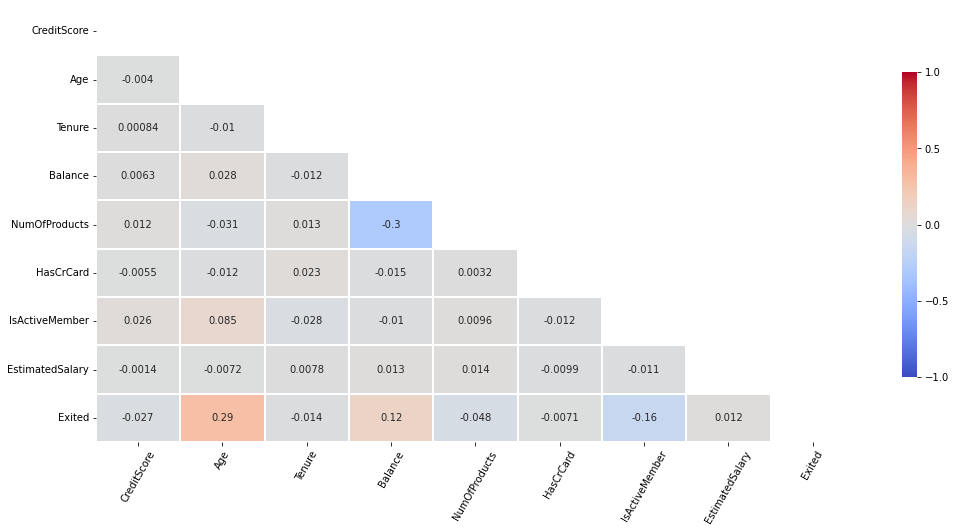

In [4]:
fig, ax = plt.subplots(figsize=(17, 8))

corr_df = df.drop('CustomerId', axis=1).corr()
sns.heatmap(corr_df,
            cmap='coolwarm',
            mask=np.triu(corr_df),
            annot=True,
            lw=1.5,
            vmin=-1,
            vmax=1,
            cbar_kws = {'shrink':0.7,
                        'ticks' :[-1, -.5, 0, 0.5, 1]})

ax.set_xticklabels(corr_df.columns, rotation = 60)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True});

In [5]:
def calc_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif

In [6]:
geography = pd.get_dummies(df['Geography'], drop_first=True)
gender = pd.get_dummies(df['Gender'], drop_first=True)

In [7]:
df = pd.concat([df,geography, gender], axis=1)

In [8]:
df.drop(['Geography','Gender'], axis=1, inplace=True)

In [9]:
df.head()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Germany,Spain,Male
0,15634602,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,15647311,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,15619304,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,15701354,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,15737888,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


In [10]:
calc_vif(df.drop('CustomerId', axis=1))

,variables,VIF
0,CreditScore,21.318076
1,Age,13.695782
2,Tenure,3.874245
3,Balance,3.187722
4,NumOfProducts,7.835278
5,HasCrCard,3.289971
6,IsActiveMember,2.151553
7,EstimatedSalary,3.887335
8,Exited,1.477960
9,Germany,1.816452


## Train test split

In [11]:
X = df.drop(['Exited'], axis=1)
y = df['Exited']

X_train, X_test, y_train, y_test = train_test_split(X.drop('CustomerId', axis=1), y, test_size=0.3, random_state=143)

## Create models and metrics

In [12]:
def create_models():
    models = {}
    models['Logistic Regression'] = LogisticRegression()
    models['KNN'] = KNeighborsClassifier()
    models['SVC'] = SVC()
    models['Linear SVC'] = LinearSVC(max_iter=5000)
    models['Decision Tree'] = DecisionTreeClassifier()
    models['Random Forest'] = RandomForestClassifier()
    models['Bayes'] = GaussianNB()
    models['LGBM'] = LGBMClassifier()
    return models

In [13]:
# metrics
def false_positive(estimator, X, y):
    predictions = estimator.predict(X)
    cm = confusion_matrix(y, predictions)
    return cm[0][1]

def true_positive(estimator, X, y):
    predictions = estimator.predict(X)
    cm = confusion_matrix(y, predictions)
    return cm[1][1]

scoring = {'fp':false_positive,
           'tp': true_positive,
           'recall':'recall',
           'precision':'precision',
           'roc_auc':'roc_auc',
           'accuracy':'accuracy'}

# cross-validation
def evaluate_score(model, X, y, scoring):
    cv = StratifiedKFold(5, shuffle=True, random_state=143)
    scaler = StandardScaler()
    
    pipeline = Pipeline(steps=[('scaler', scaler), ('model', model)])
    scores = cross_validate(pipeline, X, y, cv=cv, scoring=scoring)
    
    return scores

In [14]:
names = []
results = []

for name, model in create_models().items():
    print(f'--- Initializing {name} ---')
    scores = evaluate_score(model, X_train, y_train, scoring)
    names.append(name)
    results.append(scores)
    print(f'--- {name} done! ---')

--- Initializing Logistic Regression ---
--- Logistic Regression done! ---
--- Initializing KNN ---
--- KNN done! ---
--- Initializing SVC ---
--- SVC done! ---
--- Initializing Linear SVC ---
--- Linear SVC done! ---
--- Initializing Decision Tree ---
--- Decision Tree done! ---
--- Initializing Random Forest ---
--- Random Forest done! ---
--- Initializing Bayes ---
--- Bayes done! ---
--- Initializing LGBM ---
--- LGBM done! ---


In [15]:
test_fp = []
test_tp = []
test_recall = []
test_precision = []
test_auroc = []
test_accuracy = []
time_taken = []

for i in range(len(results)):
    test_fp.append(results[i]['test_fp'].mean())

for i in range(len(results)):
    test_tp.append(results[i]['test_tp'].mean())
    
for i in range(len(results)):
    test_recall.append(results[i]['test_recall'].mean())
    
for i in range(len(results)):
    test_precision.append(results[i]['test_precision'].mean())

for i in range(len(results)):
    test_auroc.append(results[i]['test_roc_auc'].mean())    

for i in range(len(results)):
    test_accuracy.append(results[i]['test_accuracy'].mean())
    
for i in range(len(results)):
    time_taken.append(round(results[i]['score_time'].sum(), 1) + round(results[i]['fit_time'].sum(), 1))

test_fp = pd.Series(test_fp, name='False positive')
test_tp = pd.Series(test_tp ,name='True positive')
test_recall = pd.Series(test_recall, name='Recall')
test_precision = pd.Series(test_precision, name='Precision')
test_auroc = pd.Series(test_auroc, name='AUCROC')
test_accuracy = pd.Series(test_accuracy, name='Accuracy')
time_taken = pd.Series(time_taken, name='Time to compute (seconds)')

df_result = pd.concat([test_fp, test_tp, test_recall, test_precision, test_auroc, test_accuracy, time_taken], axis=1)
df_result.index = names
df_result['Cost'] = round(((df_result['False positive'] + df_result['True positive']) * (-500)) + (df_result['True positive'] * 2000), 2)
df = df.iloc[:, [0, 1, 2, 3 ,4, 5, 7, 6]]

In [16]:
df_result.sort_values('Cost', ascending=False)

,False positive,True positive,Recall,Precision,AUCROC,Accuracy,Time to compute (seconds),Cost
LGBM,55.2,142.2,0.494098,0.720821,0.854047,0.856571,1.2,185700.0
Random Forest,41.0,133.4,0.463528,0.766999,0.850430,0.860429,4.3,179600.0
SVC,26.4,109.6,0.380841,0.807523,0.824697,0.853857,11.8,151200.0
Decision Tree,161.8,144.0,0.500341,0.470487,0.677432,0.781714,0.3,135100.0
Bayes,68.0,104.8,0.364157,0.606941,0.784587,0.820714,0.1,123200.0
KNN,65.2,103.0,0.357893,0.613125,0.762740,0.821429,3.0,121900.0
Logistic Regression,43.6,62.0,0.215445,0.589086,0.766068,0.807571,0.2,71200.0
Linear SVC,26.6,46.2,0.160538,0.637891,0.767959,0.808429,1.4,56000.0


## Training

In [17]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
model = LGBMClassifier(random_state=143)
model.fit(X_train_scaled, y_train)

LGBMClassifier(random_state=143)

In [19]:
predictions = model.predict(X_test_scaled)
auroc = roc_auc_score(y_test, predictions)
accuracy = accuracy_score(y_test, predictions)

In [20]:
print(f'AUROC: {round(auroc*100, 2):8} %')
print(f'Accuracy: {round(accuracy*100, 2)} %')

AUROC:    73.25 %
Accuracy: 86.33 %


## Hyperparameter tuning

In [21]:
def estimator(max_depth, num_leaves, learning_rate, n_estimators):
    params = {}
    params['max_depth'] = round(max_depth)
    params['num_leaves'] = round(num_leaves)
    params['learning_rate'] = learning_rate
    params['n_estimators'] = round(n_estimators)
    
    scaler = StandardScaler()
    cv = StratifiedKFold(5, shuffle=True, random_state=143)
    
    model = LGBMClassifier(random_state=143, **params)
    pipeline = Pipeline(steps=[('scaler', scaler), ('model', model)])
    
    score = cross_val_score(pipeline, X_train, y_train, scoring='roc_auc', cv=cv).mean()
    return score

params_bounds ={
    'max_depth':(5,30),
    'num_leaves':(15, 30),
    'learning_rate':(0.001, 10),
    'n_estimators':(100, 1000),
}

lgbm_bo = BayesianOptimization(estimator, params_bounds, random_state=143)
lgbm_bo.maximize(init_points=30, n_iter=5)

|   iter    |  target   | learni... | max_depth | n_esti... | num_le... |
-------------------------------------------------------------------------
|  1        |  0.5354   |  7.378    |  13.5     |  521.3    |  21.36    |
|  2        |  0.5985   |  5.684    |  27.03    |  129.8    |  15.13    |
|  3        |  0.5499   |  1.993    |  9.182    |  972.1    |  15.85    |
|  4        |  0.8094   |  0.8965   |  11.99    |  648.4    |  16.06    |
|  5        |  0.5619   |  5.725    |  13.31    |  335.5    |  16.39    |
|  6        |  0.5478   |  6.619    |  7.213    |  298.3    |  15.56    |
|  7        |  0.5239   |  1.697    |  20.49    |  458.2    |  29.43    |
|  8        |  0.5409   |  8.964    |  11.38    |  843.9    |  27.46    |
|  9        |  0.8638   |  0.02014  |  19.22    |  263.3    |  15.46    |
|  10       |  0.502    |  8.311    |  17.18    |  283.6    |  21.95    |
|  11       |  0.5312   |  7.324    |  9.159    |  368.2    |  26.99    |
|  12       |  0.5531   |  7.875    | 

In [22]:
params_lgbm = lgbm_bo.max['params']
params_lgbm['max_depth'] = round(params_lgbm['max_depth'])
params_lgbm['n_estimators'] = round(params_lgbm['n_estimators'])
params_lgbm['num_leaves'] = round(params_lgbm['num_leaves'])

In [23]:
model = LGBMClassifier(random_state=143, **params_lgbm)
model.fit(X_train_scaled, y_train)

LGBMClassifier(learning_rate=0.020137210850272987, max_depth=19,
               n_estimators=263, num_leaves=15, random_state=143)

## Feature importance

In [24]:
feat_imp = pd.DataFrame(model.feature_importances_, index=X_train.columns, columns=['Feature Importance']).sort_values('Feature Importance', ascending=False)

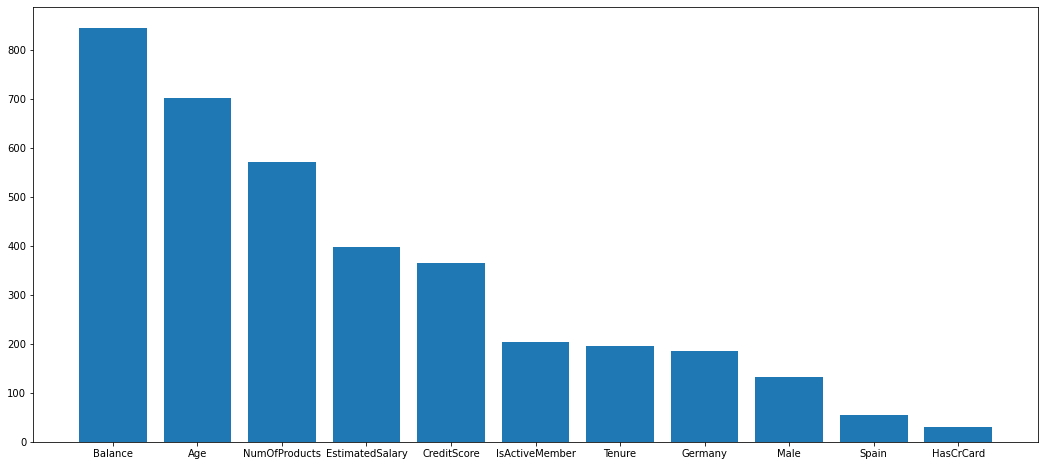

In [25]:
plt.figure(figsize=(18,8))
plt.bar(feat_imp.index, feat_imp['Feature Importance']);

In [26]:
predictions = model.predict(X_test_scaled)
score = roc_auc_score(y_test, predictions)
accuracy = accuracy_score(y_test, predictions)

In [27]:
print(f'AUROC: {round(auroc*100, 2):8} %')
print(f'Accuracy: {round(accuracy*100, 2)} %')

AUROC:    73.25 %
Accuracy: 86.73 %


## Permutation importance

In [28]:
def permutation_importance(X, y, model, metric, num_iterations=100):
    baseline = metric(y, model.predict(X))
    scores = {col:[] for col in range(len(X_test.columns))}
    
    for col in range(len(X_test.columns)):
        X_copy = X.copy()
        for _ in range(num_iterations):
            temp = X_copy[col].tolist()
            random.shuffle(temp)
            X_copy[col] = temp
            score = metric(y, model.predict(X_copy))
            scores[col].append(baseline - score)
    return baseline, scores

In [29]:
baseline, scores = permutation_importance(X_test_scaled, y_test, model, roc_auc_score, 100)

In [30]:
for i, j in enumerate(np.array(X_test.columns)):
    scores[j] = scores[i]
    del scores[i]

In [31]:
percent_changes={col:[] for col in X_test.columns}

for col in scores:
    for i in range(len(scores[col])):
        percent_changes[col].append(scores[col][i] / baseline * 100)

In [32]:
feat_imp_2 = pd.DataFrame.from_dict(percent_changes).melt().groupby(['variable']).mean().reset_index().sort_values(['value'], ascending=False)

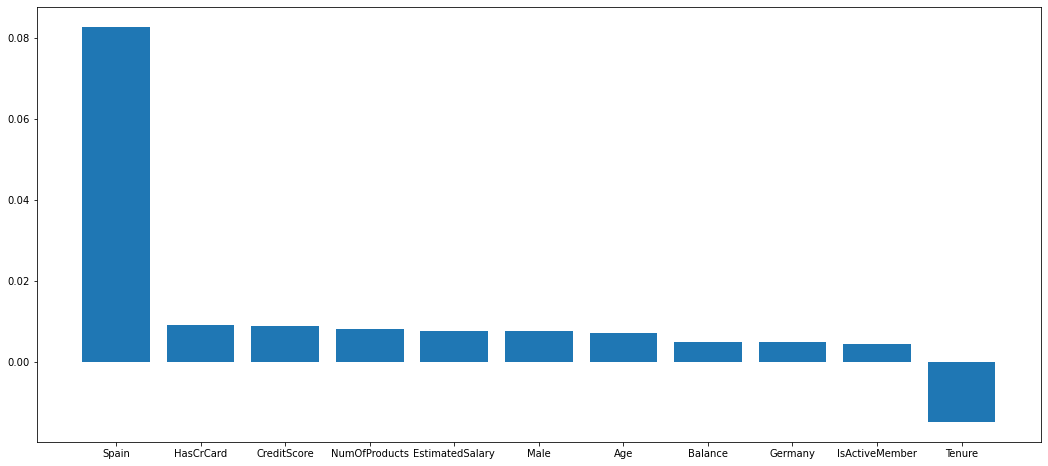

In [33]:
plt.figure(figsize=(18,8))
plt.bar(feat_imp_2['variable'], feat_imp_2['value']);

## Model prediction

In [34]:
proba = model.predict_proba(X_test_scaled)

In [35]:
df_proba = pd.Series(proba[:,1], name='Churn Probability')

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=143)

In [37]:
df_proba = pd.concat([X_test.reset_index().loc[:,'CustomerId'], df_proba], axis=1)

In [38]:
df_proba.set_index('CustomerId', inplace=True)

In [39]:
df_proba['Risk'] = df_proba['Churn Probability'].apply(lambda x: 'High' if x >= 0.8 else ('Medium' if x >= 0.6 else 'Low'))

In [40]:
df_proba.head(20)

,Churn Probability,Risk
CustomerId,,
15581539,0.028055,Low
15768120,0.047658,Low
15803456,0.434348,Low
15711015,0.023571,Low
15673074,0.170716,Low
15737910,0.075144,Low
15761783,0.214524,Low
15668853,0.187142,Low
15703106,0.026789,Low
